# MapReduce for BLUE

### Теоретическая сводка

Для реализации параллельного программирования необходимо определить особую форму записи и хранения данных. Введём понятие **"Каноническая информация"** - набор неких статистик, обладающих следующими пятью свойствами:

1. **Универсальность** - любая последовательность сырых данных ($X_1, X_2,...,X_n$) может быть представлена в виде канонической информации и в уникальном виде;
2. **Полнота** - каноническая информация сохраняет всю информацию, которая была представлена в исходных исходных данных, и ее полностью достаточно для решаемой задачи;
3. **Элементарность** - каноническая информация существует даже для одного элемента;
4. **Точка отсчёта** - каноническая информация существует при отсутствии наблюдений;
5. **Комбинируемость** - композиция разных частей канонической информации должна удовлетворять аксиоме коммутативного моноида;
6. **Обновляемость** - каноническая информация способна регулярно обновляться при поступлении новых данных, чтобы их учитывать;
7. **Компактность и эффективность** - объём памяти, необходимый для хранения постоянно обновляющейся канонической информации, в идеале не зависящий от объёма наблюдений;

### Постановка задачи

Пусть ряд наблюдений неизвестного значения x равен:

$y_i = a_ix + e_i, i = 1, ..., n$
где $y_i$ - результаты измерений, $a_i$ - известный коэффициент, а $e_i$ является случайной ошибкой измерения, при этом одинаково и независимо распределённые с нулевым средним и дисперсией $\sigma^2$:
$E\epsilon_i = 0$, $Ee_i^2 = \sigma^2$, $i = 1,...,n$

Определим каноническую информацию для оценки $x$ и его вариации Var(x)

### Определение канонической информации для задачи BLUE

Для начала аналитическим методом найдём оптимум:

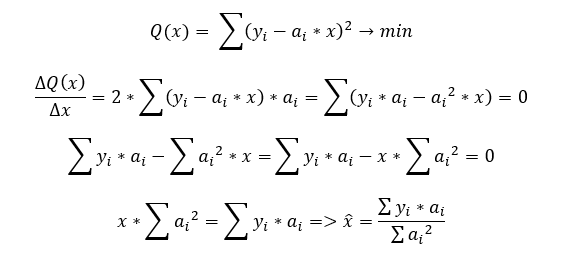

Его вариация при известной дисперсии равна:
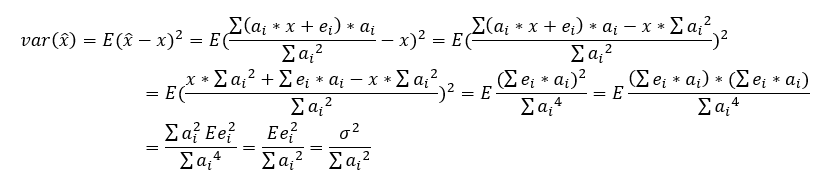

При неизвестной дисперсии, вариацию можно оценить следующим образом:
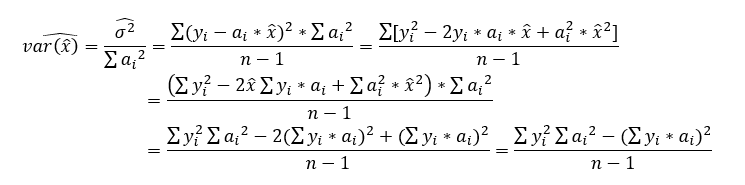

Так, можно выделить следующую форму канонической информации:

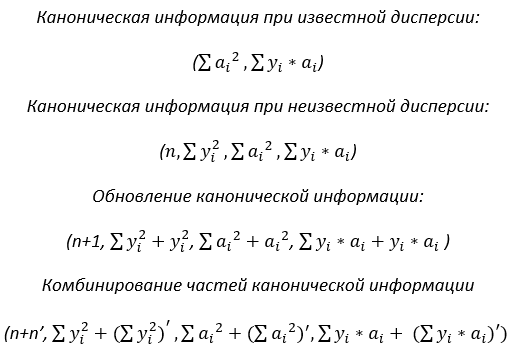

### Программная реализация

In [34]:
import numpy as np
from functools import reduce

In [97]:
# инициализируем исходные данные

n = 20
a = np.array([np.random.randint(10) for i in range(n)]) # вектор известных коэффициентов
e = np.array([np.random.randint(2) for i in range(n)]) # случайный шум
x = 30 # оцениваемый x
y = a*x + e # ряд наблюдений
X = np.array([y,a])

# Запишем в nodes срезы датасета, имитируя кластер из 4 разных машин,
# хранящих собственную часть данных из исходного датасета.
nodes = [X[:,:5], X[:,5:10], X[:,10:15], X[:,15:20]]

print('Вывожу набор исходных наблюдений:\n', y,a)
for i in range(4):
    print(f'Вывожу наблюдения, распределённые по "кластеру": Машина {i} - y = {nodes[i][0]}, a ={nodes[i][1]} ')

Вывожу набор исходных наблюдений:
 [240 211  90   0 151 151 210 210  61 241 211   0   0   0 270 271 120 241
 180 150] [8 7 3 0 5 5 7 7 2 8 7 0 0 0 9 9 4 8 6 5]
Вывожу наблюдения, распределённые по "кластеру": Машина 0 - y = [240 211  90   0 151], a =[8 7 3 0 5] 
Вывожу наблюдения, распределённые по "кластеру": Машина 1 - y = [151 210 210  61 241], a =[5 7 7 2 8] 
Вывожу наблюдения, распределённые по "кластеру": Машина 2 - y = [211   0   0   0 270], a =[7 0 0 0 9] 
Вывожу наблюдения, распределённые по "кластеру": Машина 3 - y = [271 120 241 180 150], a =[9 4 8 6 5] 


In [126]:
# определим функции MapReduce для BLUE

def BLUE_map(X):
    '''
    Преобразует данные о наблюдениях в форму канонической информации
    n, S, T, U.
    '''
    n = X.shape[1]
    S = np.sum(np.square(X[0]))
    T = np.sum(np.square(X[1]))
    U = np.sum(X[0]*X[1])
    return n, S, T, U

def BLUE_reduce(x, y):
    """
    Суммирует соответствующую каноническую информацию воедино,
    возвращая каноническую информацию об исходном датасете.
    """
    return x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3]

def BLUE_result(r):
    '''
    Вычисляет оптимальное значение x, используя
    каноническую информацию об исходном датасете.
    '''
    VarX = (r[1]*r[2] - r[3])/(r[0] - 1)
    X = r[3]/r[2] 
    return VarX, X

In [127]:
# Протестируем итог

X = BLUE_result(reduce(BLUE_reduce, map(BLUE_map, nodes)))

print(f'Истинный x = 30, рассчитанный = {X[1]}')


Истинный x = 30, рассчитанный = 30.07391304347826
